<a href="https://colab.research.google.com/github/selfor21/EBAC-SLF-230210/blob/main/IMD04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KAGGLE - INTERMERDIATE MACHINE LEARNING - EXERCÍCIO 04

Introduction
In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

<ipython-input-2-d57511d72f78>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('spotify.csv')


In [6]:
spotify.shape

(32833, 23)

In [12]:
spotify.head(1).T

,0
track_id,6f807x0ima9a1j3VPbc7VN
track_name,I Don't Care (with Justin Bieber) - Loud Luxur...
track_artist,Ed Sheeran
track_popularity,66
track_album_id,2oCs0DGTsRO98Gh5ZSl2Cx
track_album_name,I Don't Care (with Justin Bieber) [Loud Luxury...
track_album_release_date,2019-06-14
playlist_name,Pop Remix
playlist_id,37i9dQZF1DXcZDD7cfEKhW
playlist_genre,pop


In [11]:
spotify.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [14]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [15]:
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


##Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the Spotify dataset.

<Axes: >

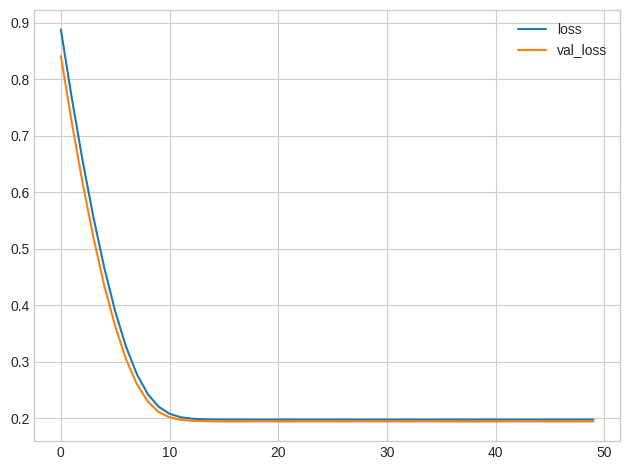

In [16]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()


It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1940


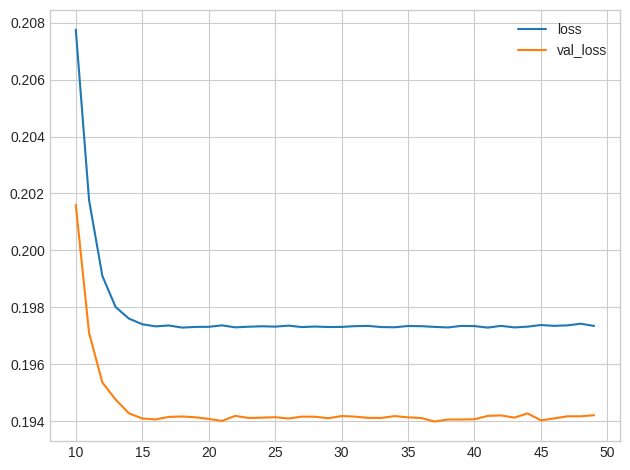

In [17]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

##1) Evaluate Baseline
> What do you think? Would you say this model is underfitting, overfitting, just right?

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 1s 8ms/step - loss: 0.2392 - val_loss: 0.2057
Epoch 2/50
49/49 [==============================] - 0s 5ms/step - loss: 0.2014 - val_loss: 0.1987
Epoch 3/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1968 - val_loss: 0.1963
Epoch 4/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1938 - val_loss: 0.1963
Epoch 5/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1925 - val_loss: 0.1959
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1909 - val_loss: 0.1966
Epoch 7/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1894 - val_loss: 0.1945
Epoch 8/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1881 - val_loss: 0.1937
Epoch 9/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1871 - val_loss: 0.1955
Epoch 10/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1857 - val_loss: 0.1942
Epoch 11/50
49/49 [

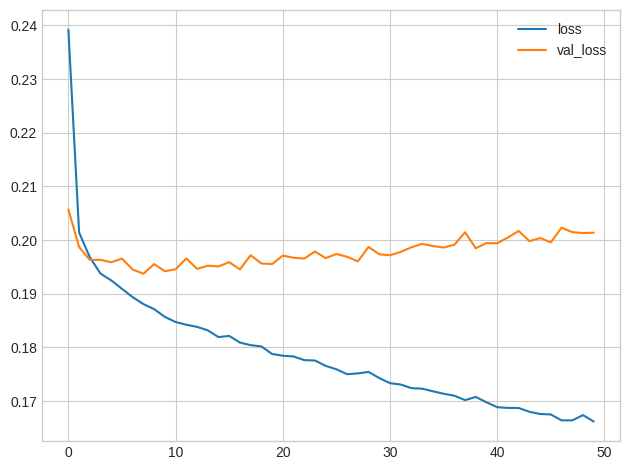

In [18]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [19]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Now run this cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

Epoch 1/50
49/49 [==============================] - 1s 7ms/step - loss: 0.2551 - val_loss: 0.2088
Epoch 2/50
49/49 [==============================] - 0s 6ms/step - loss: 0.2037 - val_loss: 0.1998
Epoch 3/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1982 - val_loss: 0.1981
Epoch 4/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1954 - val_loss: 0.1958
Epoch 5/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1929 - val_loss: 0.1947
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1910 - val_loss: 0.1948
Epoch 7/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1899 - val_loss: 0.1943
Epoch 8/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1884 - val_loss: 0.1939
Epoch 9/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1874 - val_loss: 0.1944
Epoch 10/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1866 - val_loss: 0.1932
Epoch 11/50
49/49 [

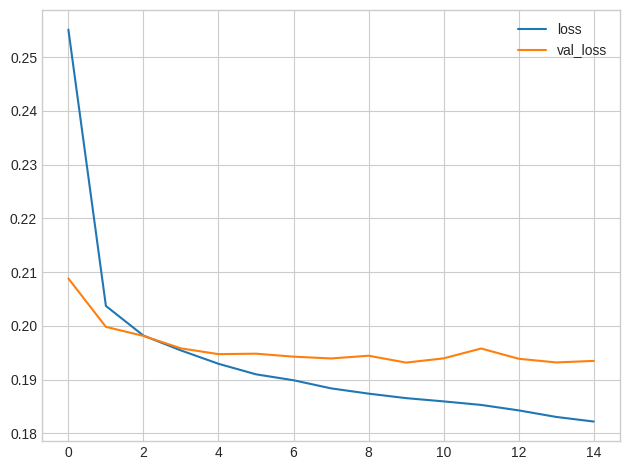

In [20]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?